In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

In [3]:
with open('null.txt', 'w') as f:
    f.write(null_counts.to_string())

NameError: name 'null_counts' is not defined

In [4]:
df = df.dropna()

In [5]:
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [6]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Label' column
df[' Label'] = label_encoder.fit_transform(df[' Label'])

# Print the mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'BENIGN': 0, 'DDoS': 1}


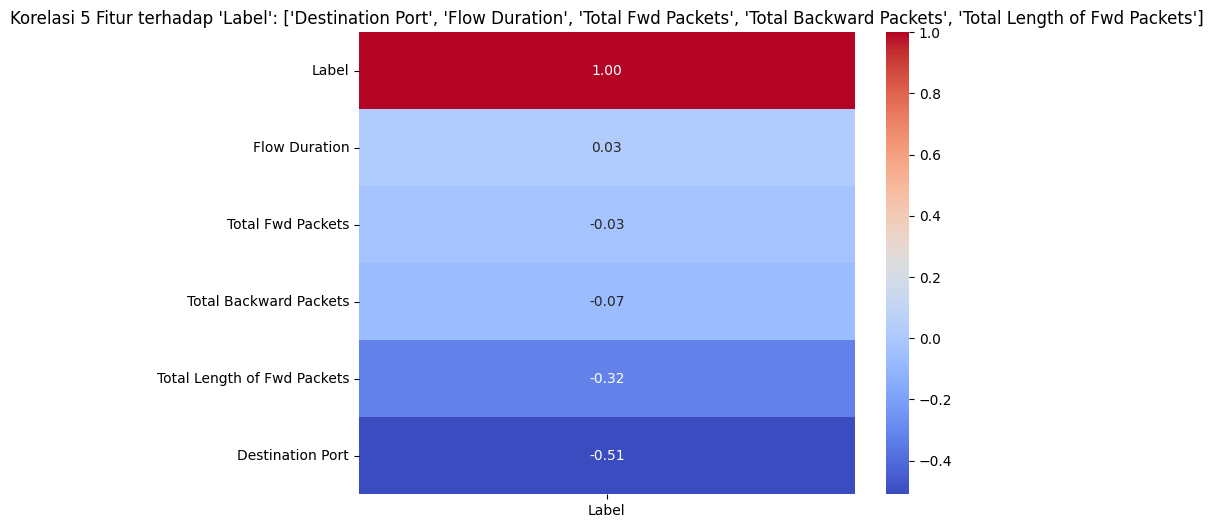

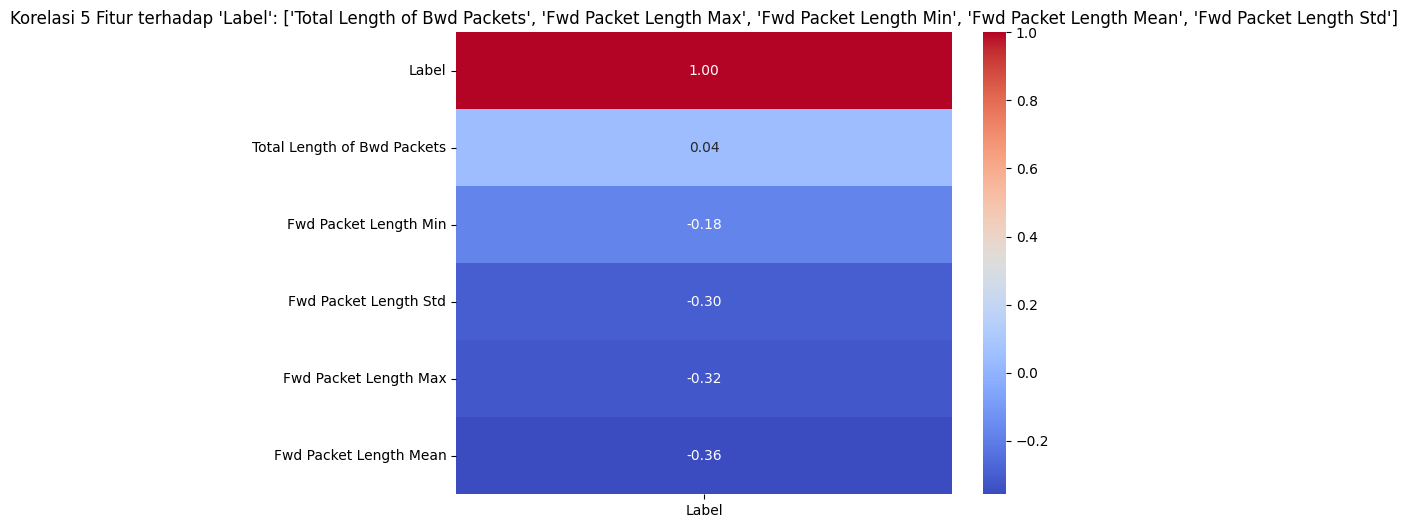

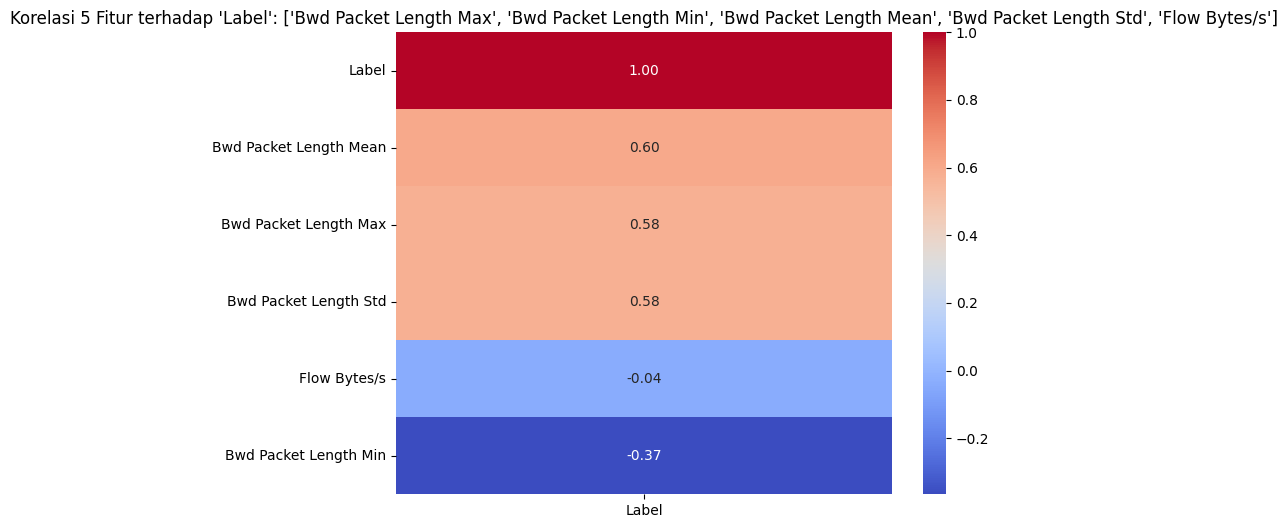

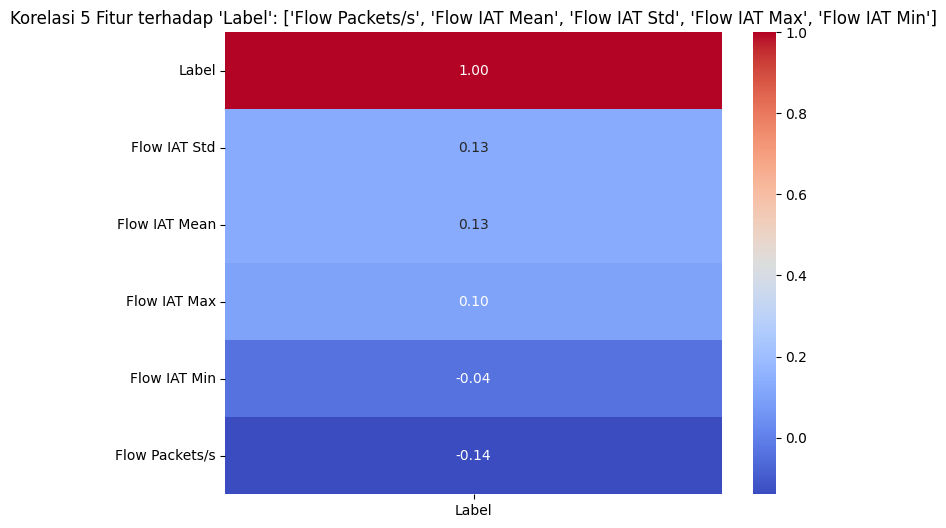

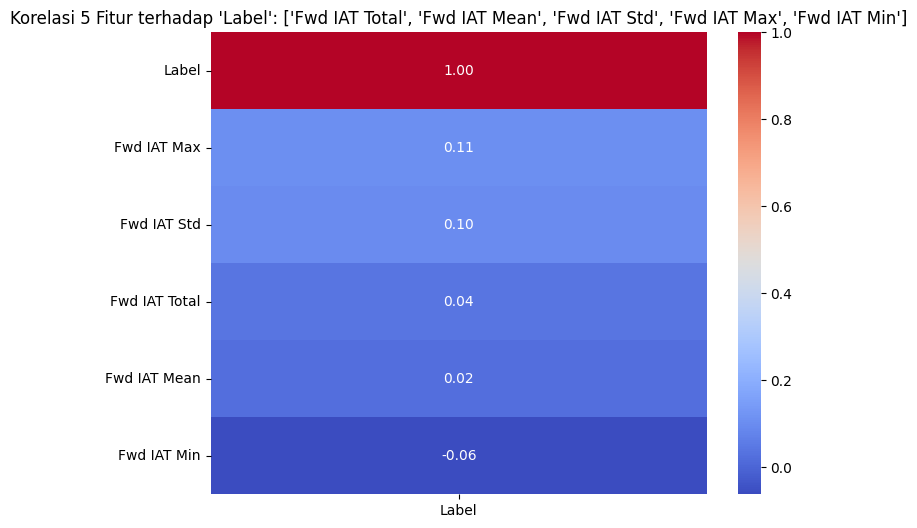

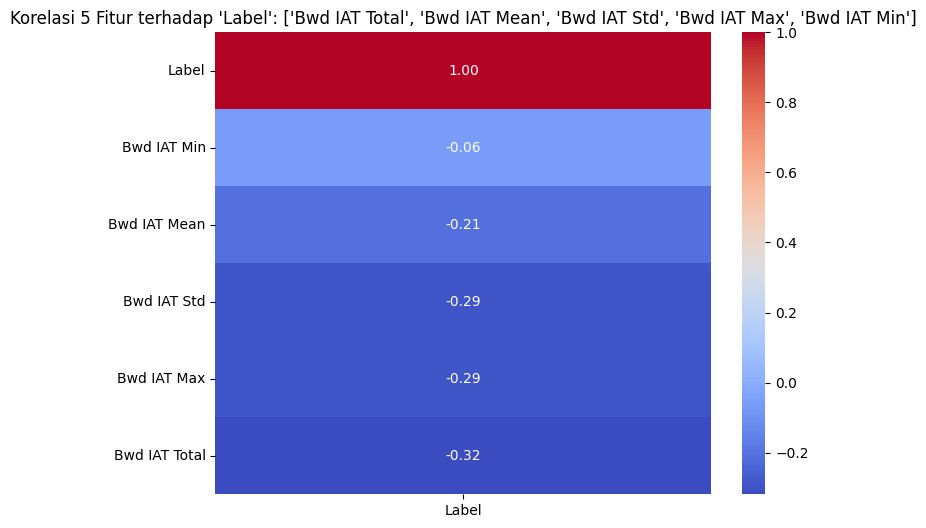

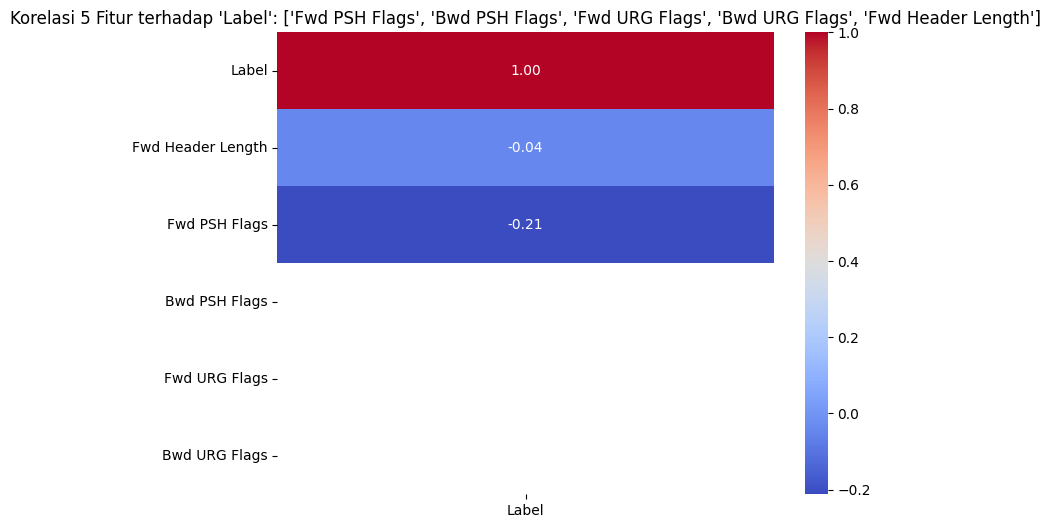

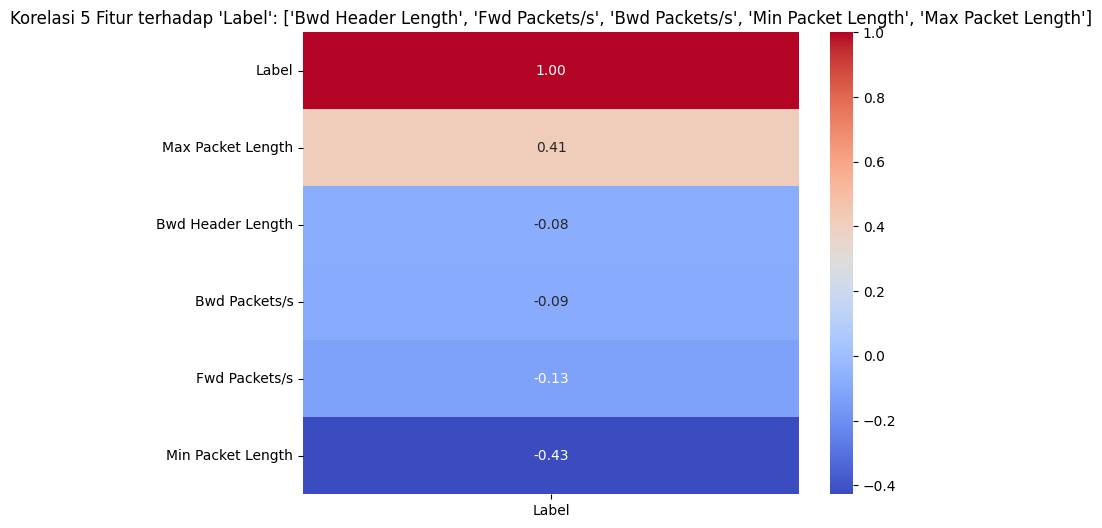

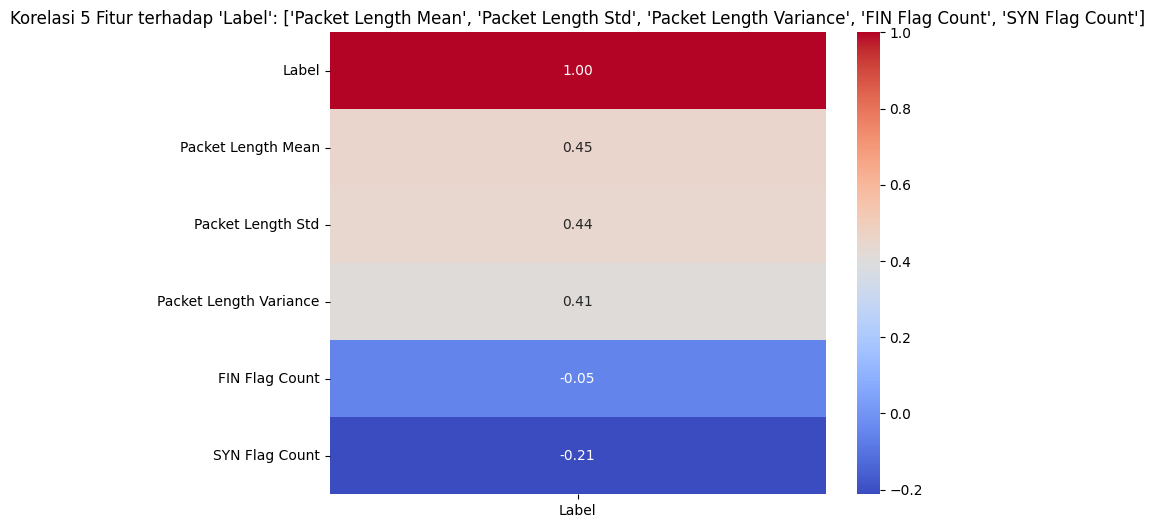

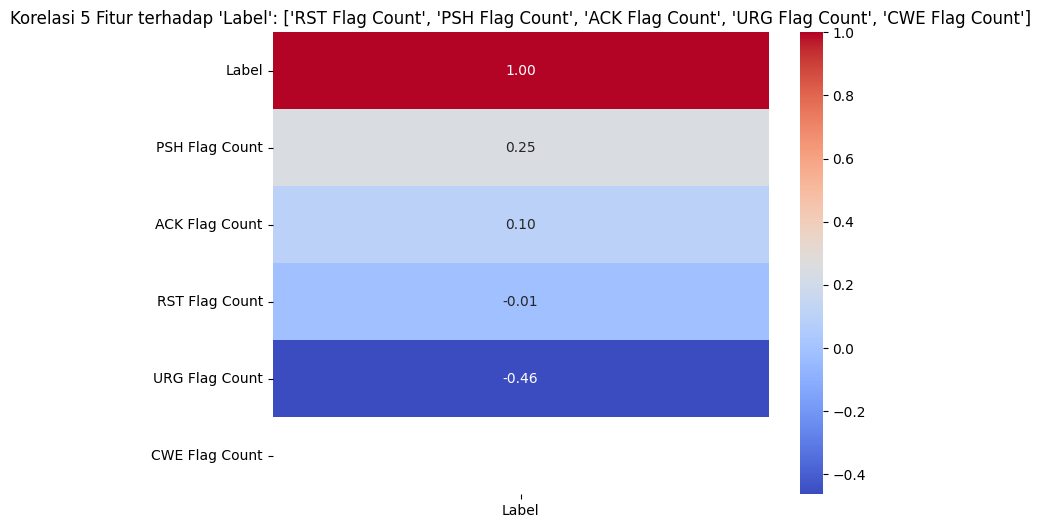

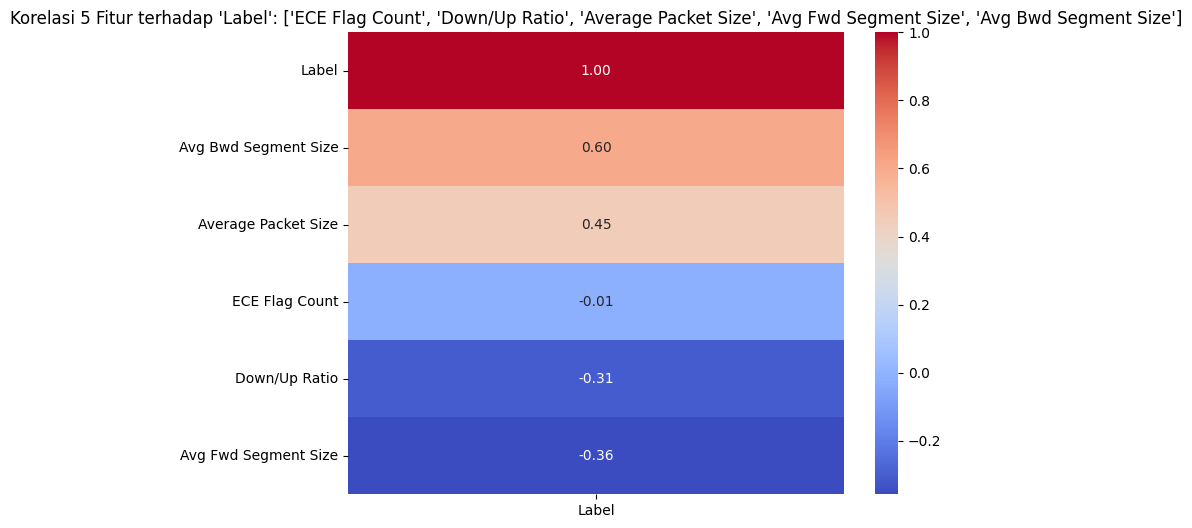

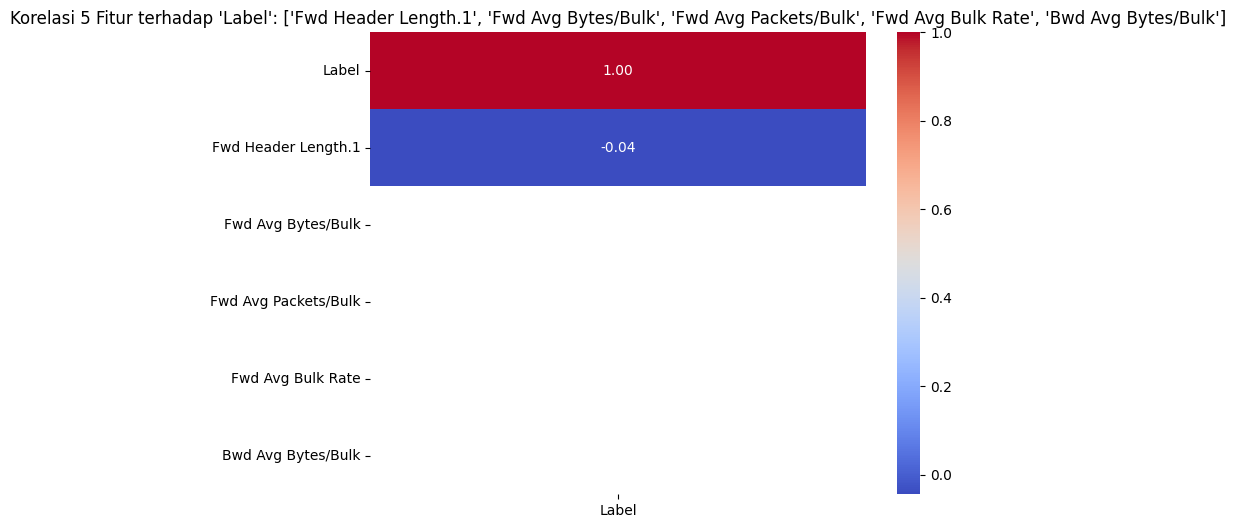

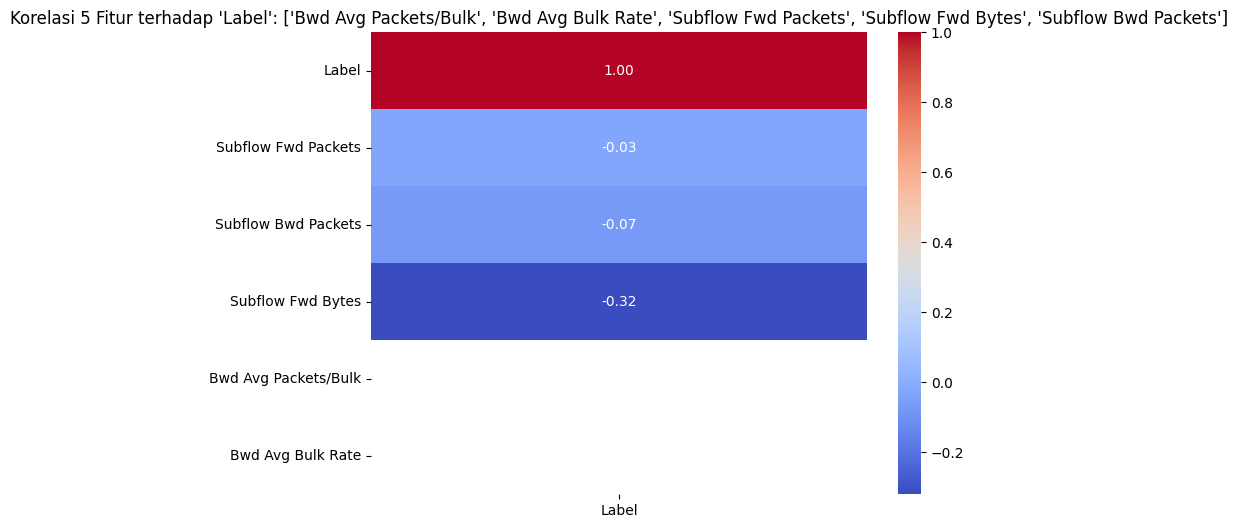

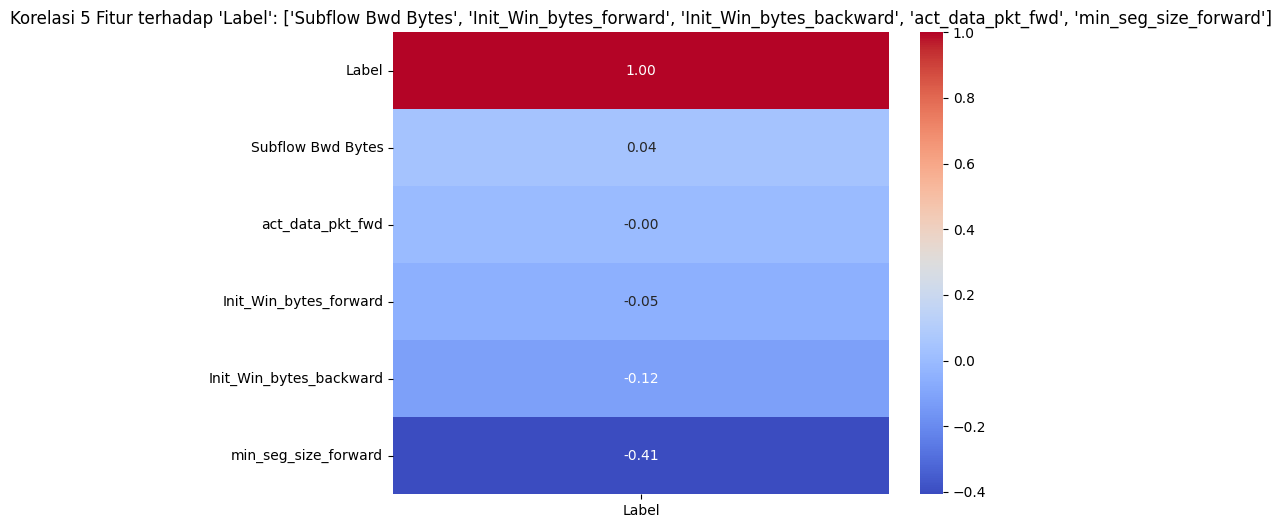

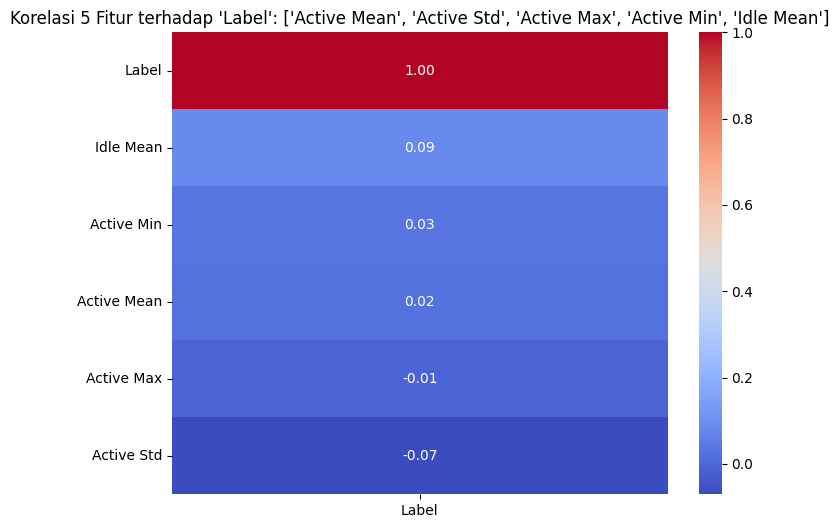

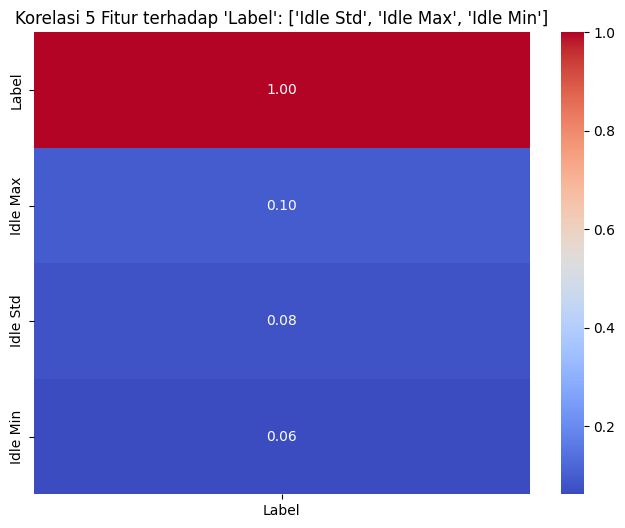

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Bersihkan nama kolom dengan menghapus spasi ekstra di awal/akhir
df.columns = df.columns.str.strip()

# Daftar kolom (fitur) selain 'Label'
features = [col for col in df.columns if col != 'Label']

# Membagi fitur menjadi kelompok per 5
chunk_size = 5
feature_chunks = [features[i:i + chunk_size] for i in range(0, len(features), chunk_size)]

# Plot heatmap untuk setiap kelompok
for chunk in feature_chunks:
    subset = chunk + ['Label']  # Tambahkan kolom 'Label'
    corr = df[subset].corr()    # Hitung korelasi untuk subset
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr[['Label']].sort_values(by='Label', ascending=False), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f"Korelasi 5 Fitur terhadap 'Label': {chunk}")
    plt.show()


In [8]:

df = df[['Destination Port', 'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Max Packet Length', 'Min Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Avg Bwd Segment Size', 'Average Packet Size', 'Label']]

In [9]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Bagi dataframe menjadi df_train dan df_test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Label'])

# Inisialisasi RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Pisahkan fitur dan label
X_train = df_train.drop('Label', axis=1)
y_train = df_train['Label']

# Terapkan undersampling untuk menyeimbangkan label
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)



In [10]:
from sklearn.preprocessing import MinMaxScaler

# Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

# Normalisasi fitur
X_train_res_scaled = scaler.fit_transform(X_train_res)

# Reshape data menjadi bentuk [samples, timesteps, features]
# Dalam kasus ini, kita anggap setiap sampel memiliki 1 timestep
X_train_res_reshaped = X_train_res_scaled.reshape((X_train_res_scaled.shape[0], 1, X_train_res_scaled.shape[1]))

# Tampilkan shape dari data yang telah di-reshape
print("Shape of X_train_res_reshaped:", X_train_res_reshaped.shape)

Shape of X_train_res_reshaped: (156342, 1, 11)


In [12]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [45]:
from keras.layers import Reshape

model1 = Sequential(
    [
        LSTM(128, input_shape=(X_train_res_reshaped.shape[1], X_train_res_reshaped.shape[2]), return_sequences=True),
        Dropout(0.3),
        Dense(64),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.2),
        Reshape((1, 32)),  # Reshape the output to 3D tensor
        LSTM(16, activation='tanh'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ]
)
model1.summary()

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 1, 128)         │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,505 (373.07 KB)

 Trainable params: 95,505 (373.07 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
from keras.optimizers import Adam

# Compile the model with Adam optimizer and a learning rate of 0.00001
model1.compile(optimizer=Adam(learning_rate=0.000001), loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
train = model1.fit(X_train_res_reshaped,y_train_res, epochs=10, batch_size=32, validation_split=0.2)
train

Epoch 1/10
3909/3909 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.6785 - loss: 0.6926 - val_accuracy: 0.0489 - val_loss: 0.6958
Epoch 2/10
3909/3909 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6658 - loss: 0.6905 - val_accuracy: 0.0758 - val_loss: 0.6984
Epoch 3/10
3909/3909 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.6764 - loss: 0.6877 - val_accuracy: 0.2196 - val_loss: 0.7003
Epoch 4/10
3909/3909 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.7144 - loss: 0.6839 - val_accuracy: 0.3293 - val_loss: 0.7010
Epoch 5/10
3909/3909 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.7612 - loss: 0.6788 - val_accuracy: 0.4798 - val_loss: 0.6999
Epoch 6/10
3909/3909 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8099 - loss: 0.6717 - val_accuracy: 0.5868 - val_loss: 0.6967
Epoch 7/10
3909/3909 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8437 - loss: 0.6621 - val_accuracy: 0.6253 - val_loss: 0.6908
Epoch 8/10
3909/3909 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.8532 - loss: 0

In [48]:
from sklearn.metrics import f1_score

# Pisahkan fitur dan label untuk df_test
X_test = df_test.drop('Label', axis=1)
y_test = df_test['Label']

# Normalisasi fitur menggunakan scaler yang telah dilatih
X_test_scaled = scaler.transform(X_test)

# Reshape data menjadi bentuk [samples, timesteps, features]
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Lakukan prediksi menggunakan model yang telah dilatih
y_pred = model1.predict(X_test_reshaped)
y_pred = (y_pred > 0.5).astype(int)

# Hitung f1-score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

1411/1411 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
F1 Score: 0.7710448894372213
